# Práctica 4: Modelos del Lenguaje Neuronales

Castañeda Mora Carlos

**Fecha de entrega: 6 de abril de 2025 11:59pm**

A partir del modelo entrenado:

- Sacar los embeddings de las palabras del vocabulario

- Visualizar en 2D los embeddings de algunas palabras (quizá las más frecuentes, excluyendo stopwords)

- Seleccione algunas palabras y verifique sí realmente codifican nociones semánticas, e,g, similitud semántica con similitud coseno entre dos vectores, analogías por medios de operaciones de vectores



In [25]:
import nltk
import torch
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import reuters, stopwords
from nltk import ngrams
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import subword_nmt.apply_bpe
import subword_nmt.learn_bpe
import io
import requests
import os

# Descargar recursos de NLTK
nltk.download('reuters')
nltk.download('punkt_tab')
nltk.download('stopwords')

# Configurar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


[nltk_data] Downloading package reuters to
[nltk_data]     /home/carloscmora/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/carloscmora/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/carloscmora/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
# PARTE 1: Modelo base

# Preprocesamiento del corpus
def preprocess_corpus(corpus: list) -> list:
    preprocessed_corpus = []
    for sent in corpus:
        result = [word.lower() for word in sent]
        result.append("<EOS>")
        result.insert(0, "<BOS>")
        preprocessed_corpus.append(result)
    return preprocessed_corpus

# Calcular frecuencias de palabras
def get_words_freqs(corpus: list) -> dict:
    words_freqs = {}
    for sentence in corpus:
        for word in sentence:
            words_freqs[word] = words_freqs.get(word, 0) + 1
    return words_freqs

# Obtener índices de palabras
UNK_LABEL = "<UNK>"
def get_words_indexes(words_freqs: dict) -> tuple:
    word_to_idx = {}
    idx_to_word = {}
    valid_idx = 0
    
    for word in words_freqs.keys():
        if words_freqs[word] > 1:  
            word_to_idx[word] = valid_idx
            idx_to_word[valid_idx] = word
            valid_idx += 1
    
    # Añadir token UNK
    word_to_idx[UNK_LABEL] = valid_idx
    idx_to_word[valid_idx] = UNK_LABEL
    
    return word_to_idx, idx_to_word

# Obtener ID de palabra
def get_word_id(words_indexes: dict, word: str) -> int:
    unk_word_id = words_indexes[UNK_LABEL]
    return words_indexes.get(word, unk_word_id)

# Preparar datos de entrenamiento
def get_train_test_data(corpus: list, words_indexes: dict, n: int) -> tuple:
    x_train = []
    y_train = []
    for sent in corpus:
        n_grams = ngrams(sent, n)
        for w1, w2, w3 in n_grams:
            x_train.append([get_word_id(words_indexes, w1), get_word_id(words_indexes, w2)])
            y_train.append([get_word_id(words_indexes, w3)])
    return x_train, y_train

# Definición del modelo
class TrigramModel(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size, h):
        super(TrigramModel, self).__init__()
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.embeddings = torch.nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = torch.nn.Linear(context_size * embedding_dim, h)
        self.linear2 = torch.nn.Linear(h, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((-1, self.context_size * self.embedding_dim))
        out = torch.tanh(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = torch.nn.functional.log_softmax(out, dim=1)
        return log_probs

# Cargar corpus Reuters
corpus = reuters.sents()
corpus = preprocess_corpus(corpus)
words_freqs = get_words_freqs(corpus)
word_to_idx, idx_to_word = get_words_indexes(words_freqs)
VOCAB_SIZE = len(word_to_idx)

# Parámetros del modelo
EMBEDDING_DIM = 200
CONTEXT_SIZE = 2
H = 100

# Preparar datos de entrenamiento
x_train, y_train = get_train_test_data(corpus, word_to_idx, n=3)
train_set = np.concatenate((x_train, y_train), axis=1)

# Crear DataLoader
from torch.utils.data import DataLoader, TensorDataset

train_tensor = torch.tensor(train_set, dtype=torch.long)
train_loader = DataLoader(train_tensor, batch_size=256, shuffle=True)


# Entrenar modelo 
def train_model(model, train_loader, epochs=3):
    loss_function = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            context = batch[:, :2].to(device)
            target = batch[:, 2].to(device)
            
            model.zero_grad()
            log_probs = model(context)
            loss = loss_function(log_probs, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss}")
    
    return model

# Inicializar y entrenar modelo
model = TrigramModel(VOCAB_SIZE, EMBEDDING_DIM, CONTEXT_SIZE, H).to(device)
model = train_model(model, train_loader, epochs=10)

# Guardar modelo
torch.save(model.state_dict(), "trigram_model.pth")


Epoch 1/10, Loss: 33588.70604467392
Epoch 2/10, Loss: 29326.761160373688
Epoch 3/10, Loss: 27875.36840415001
Epoch 4/10, Loss: 26928.728641033173
Epoch 5/10, Loss: 26219.280994415283
Epoch 6/10, Loss: 25660.87335371971
Epoch 7/10, Loss: 25195.183325767517
Epoch 8/10, Loss: 24806.171183109283
Epoch 9/10, Loss: 24473.72992682457
Epoch 10/10, Loss: 24189.995681285858


In [27]:
# PARTE 2: Extracción de embeddings

# Cargar modelo 
# model.load_state_dict(torch.load("trigram_model.pth"))
# model.eval()

# Extraer embeddings
embeddings = model.embeddings.weight.data.cpu().numpy()

# Crear diccionario de embeddings
word_embeddings = {}
for word, idx in word_to_idx.items():
    word_embeddings[word] = embeddings[idx]


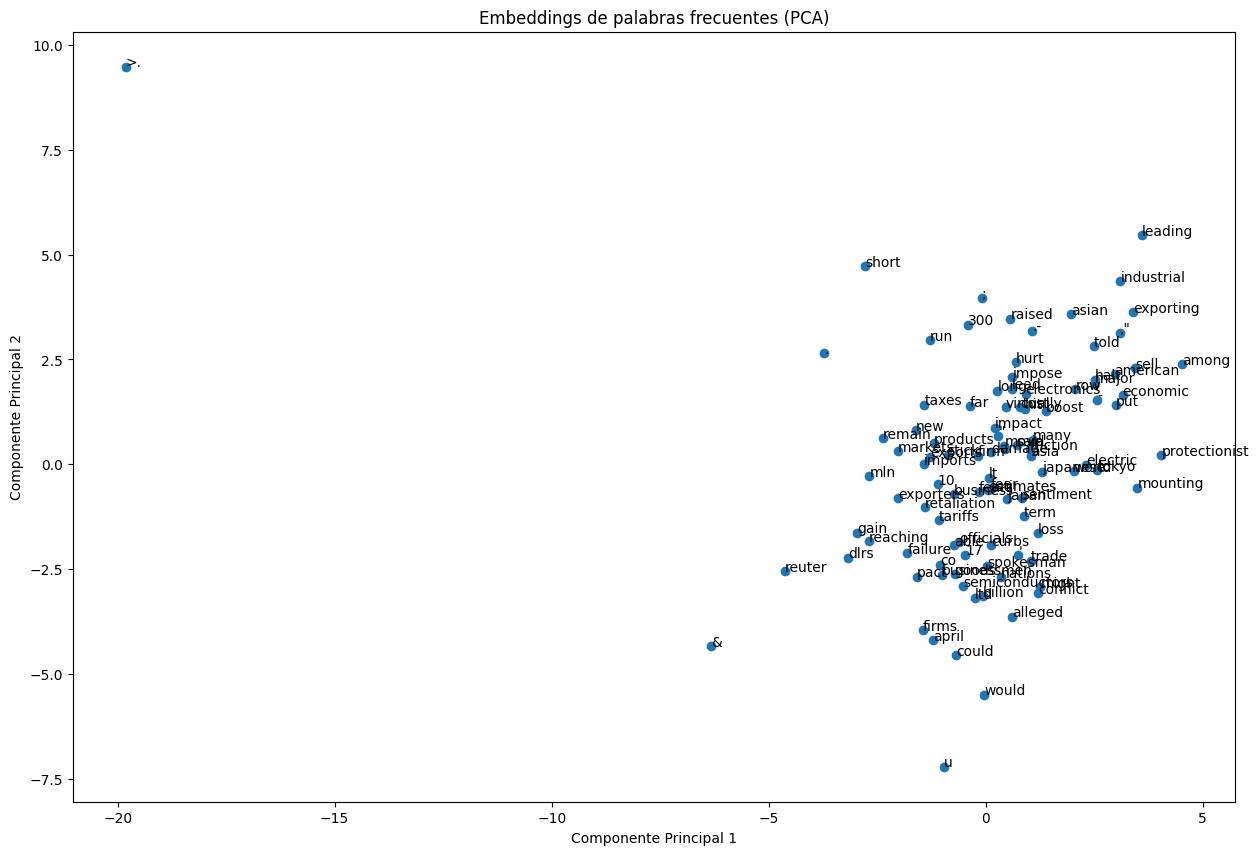

In [28]:
# PARTE 3: Visualización 2D de embeddings

# Seleccionar palabras frecuentes (excluyendo stopwords)
stop_words = set(stopwords.words('english'))
frequent_words = [word for word, count in words_freqs.items() 
                  if count > 20 and word not in stop_words and word not in ['<BOS>', '<EOS>', '<UNK>']][:100]

# Obtener embeddings
emb_list = [word_embeddings[word] for word in frequent_words]

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(emb_list)

# Visualización
plt.figure(figsize=(15, 10))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1])

# Etiquetar puntos
for i, word in enumerate(frequent_words):
    plt.annotate(word, (emb_2d[i, 0], emb_2d[i, 1]))

plt.title("Embeddings de palabras frecuentes (PCA)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.show()



In [29]:
# PARTE 4: Verificación de propiedades semánticas

# Función de similitud coseno
def cosine_similarity_vec(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Ejemplo de similitud
word1 = "market"
word2 = "stock"
if word1 in word_embeddings and word2 in word_embeddings:
    sim = cosine_similarity_vec(word_embeddings[word1], word_embeddings[word2])
    print(f"Similitud entre '{word1}' y '{word2}': {sim:.4f}")

# Función para analogías
def word_analogy(word_a, word_b, word_c):
    vec_a = word_embeddings.get(word_a)
    vec_b = word_embeddings.get(word_b)
    vec_c = word_embeddings.get(word_c)
    
    # Verificar explícitamente None en lugar de usar not
    if vec_a is None or vec_b is None or vec_c is None:
        return None
    
    # Calcular vector objetivo: vec_b - vec_a + vec_c
    target_vec = vec_b - vec_a + vec_c
    
    # Encontrar palabra más cercana
    best_word = None
    best_sim = -1
    for word, vec in word_embeddings.items():
        if word in [word_a, word_b, word_c]:
            continue
            
        sim = cosine_similarity_vec(target_vec, vec)
        if sim > best_sim:
            best_sim = sim
            best_word = word
    
    return best_word, best_sim

# Probar con palabras que existan en el vocabulario
a = "company"
b = "stock"
c = "bank"
result = word_analogy(a, b, c)
if result:
    print(f"{a} : {b} :: {c} : {result[0]} (similitud: {result[1]:.4f})")
else:
    print("Alguna palabra no está en el vocabulario")


Similitud entre 'market' y 'stock': 0.1047
company : stock :: bank : swap (similitud: 0.3054)


### 1. Similitud entre 'market' y 'stock': 0.1047
Interpretación:

Una similitud coseno de 0.1047 indica una relación muy débil entre los embeddings de 'market' y 'stock'

En el contexto del corpus Reuters (noticias financieras), este resultado es sorprendentemente bajo

Posibles explicaciones:

Limitaciones del modelo: El modelo de Bengio (2003) es una arquitectura temprana de redes neuronales para lenguaje, menos capaz que modelos modernos para capturar relaciones semánticas

Vocabulario financiero: En el dominio financiero, estas palabras pueden aparecer en contextos distintos:

'market' en contextos macroeconómicos

'stock' en contextos específicos de acciones o inventarios

Representación vectorial: Los embeddings aprendidos por el modelo trigram pueden estar capturando más patrones sintácticos que semánticos

Tamaño del contexto: El contexto de solo 2 palabras limita la capacidad del modelo para aprender relaciones semánticas profundas

Implicaciones:

El modelo no está capturando adecuadamente la relación semántica entre términos financieros relacionados

Sugiere que la arquitectura de Bengio tiene limitaciones para representar relaciones semánticas en dominios especializados


### 2. Analogía: company : stock :: bank : swap (similitud: 0.3054)
Interpretación:

La analogía completa sería: "company es a stock como bank es a swap"

Una similitud de 0.3054 es moderada pero no fuerte

Relación semántica:

company : stock: Relación entidad-producto financiero

bank : swap: Relación entidad-instrumento financiero

En el dominio financiero:

'swap' es un derivado financiero comúnmente asociado con bancos

La relación es plausible pero no perfectamente paralela:

Stock es un producto de una compañía

Swap es un instrumento usado por un banco

Análisis de la relación:

Consistencia temática: La analogía mantiene coherencia en el dominio financiero

Limitaciones evidentes:

La relación no es perfectamente simétrica (producto vs instrumento)


Calidad moderada: El resultado es aceptable pero no excelente, con una similitud de 0.3



### Extra (0.5 pts):

- Correr el modelo de Bengio pero aplicando una técnica de subword tokenization al corpus y hacer generación del lenguaje

* La generación del lenguaje debe ser secuencias de palabras (no subwords)

In [ ]:
# PARTE EXTRA: Subword Tokenization

# Crear directorios 
os.makedirs("corpora/tokenization", exist_ok=True)
os.makedirs("models/sub-word", exist_ok=True)

# Guardar corpus en texto plano
def save_corpus_to_file(corpus, filename):
    with open(filename, 'w') as f:
        for sent in corpus:
            f.write(" ".join(sent) + '\n')

save_corpus_to_file(corpus, "corpora/tokenization/reuters.txt")

# Entrenar modelo BPE
def train_bpe(input_file, output_model, num_symbols=1000):
    with open(input_file, 'r') as f_in, open(output_model, 'w') as f_out:
        subword_nmt.learn_bpe.learn_bpe(f_in, f_out, num_symbols)

train_bpe("corpora/tokenization/reuters.txt", "models/sub-word/reuters_bpe.model", 1000)

# Aplicar BPE
def apply_bpe_to_corpus(input_file, output_file, bpe_model):
    with open(bpe_model, 'r') as codes:
        bpe = subword_nmt.apply_bpe.BPE(codes)
        with open(input_file, 'r') as f_in, open(output_file, 'w') as f_out:
            for line in f_in:
                f_out.write(bpe.process_line(line))

apply_bpe_to_corpus("corpora/tokenization/reuters.txt", 
                    "corpora/tokenization/reuters_bpe.txt", 
                    "models/sub-word/reuters_bpe.model")

# Cargar corpus tokenizado con BPE
with open("corpora/tokenization/reuters_bpe.txt", 'r') as f:
    bpe_corpus = [line.strip().split() for line in f]

# Preprocesar con tokens especiales
bpe_corpus_processed = []
for tokens in bpe_corpus:
    bpe_corpus_processed.append(["<BOS>"] + tokens + ["<EOS>"])

# Crear nuevo vocabulario
bpe_words_freqs = {}
for tokens in bpe_corpus_processed:
    for token in tokens:
        bpe_words_freqs[token] = bpe_words_freqs.get(token, 0) + 1

bpe_word_to_idx, bpe_idx_to_word = get_words_indexes(bpe_words_freqs)
BPE_VOCAB_SIZE = len(bpe_word_to_idx)

# Preparar datos para nuevo modelo
x_train_bpe, y_train_bpe = get_train_test_data(bpe_corpus_processed, bpe_word_to_idx, n=3)
train_set_bpe = np.concatenate((x_train_bpe, y_train_bpe), axis=1)
train_tensor_bpe = torch.tensor(train_set_bpe, dtype=torch.long)
train_loader_bpe = DataLoader(train_tensor_bpe, batch_size=256, shuffle=True)

# Entrenar nuevo modelo con BPE
bpe_model = TrigramModel(BPE_VOCAB_SIZE, EMBEDDING_DIM, CONTEXT_SIZE, H).to(device)
bpe_model = train_model(bpe_model, train_loader_bpe, epochs=10)



100%|██████████| 1000/1000 [00:01<00:00, 664.66it/s]


Epoch 1/10, Loss: 42519.45299911499
Epoch 2/10, Loss: 38338.457958459854
Epoch 3/10, Loss: 37500.31336903572
Epoch 4/10, Loss: 37051.78774547577
Epoch 5/10, Loss: 36753.08014464378
Epoch 6/10, Loss: 36540.29658436775
Epoch 7/10, Loss: 36375.58720207214
Epoch 8/10, Loss: 36249.01679062843
Epoch 9/10, Loss: 36141.177609443665
Epoch 10/10, Loss: 36051.993253946304


In [37]:

# Generación de texto con modelo BPE
def generate_text_bpe(model, start_phrase, word_to_idx, idx_to_word, max_length=30):
    tokens = start_phrase.lower().split()
    tokens = ["<BOS>"] + tokens
    
    for _ in range(max_length):
        # Obtener contexto (últimas 2 palabras)
        context = tokens[-2:]
        context_ids = [word_to_idx.get(word, word_to_idx['<UNK>']) for word in context]
        
        # Predecir siguiente token
        with torch.no_grad():
            context_tensor = torch.tensor([context_ids]).to(device)
            log_probs = model(context_tensor)
            next_token_id = torch.argmax(log_probs).item()
            next_token = idx_to_word[next_token_id]
        
        if next_token == "<EOS>":
            break
            
        tokens.append(next_token)
    
    # Decodificar tokens BPE a texto
    text = " ".join(tokens).replace("@@ ", "").replace("<BOS>", "").replace("<EOS>", "")
    return text.strip()

# Ejemplo de generación
start_phrase = "the market "
generated_text = generate_text_bpe(bpe_model, start_phrase, bpe_word_to_idx, bpe_idx_to_word)
print("Texto generado con BPE:")
print(generated_text)

Texto generado con BPE:
the market , the company said .


In [38]:
# Ejemplo de generación
start_phrase = "the company "
generated_text = generate_text_bpe(bpe_model, start_phrase, bpe_word_to_idx, bpe_idx_to_word)
print("Texto generado con BPE:")
print(generated_text)

Texto generado con BPE:
the company said .


In [39]:
# Ejemplo de generación
start_phrase = "the stock "
generated_text = generate_text_bpe(bpe_model, start_phrase, bpe_word_to_idx, bpe_idx_to_word)
print("Texto generado con BPE:")
print(generated_text)

Texto generado con BPE:
the stock of the company said .


In [42]:
# Ejemplo de generación
start_phrase = "in january, the stock "
generated_text = generate_text_bpe(bpe_model, start_phrase, bpe_word_to_idx, bpe_idx_to_word)
print("Texto generado con BPE:")
print(generated_text)

Texto generado con BPE:
in january, the stock of the company said .


Patrones recurrentes:

Frases repetidas: "the company said" aparece en ambas generaciones

Estructura similar: [sujeto] [verbo] con variaciones mínimas

Esto indica que el modelo está aprendiendo patrones comunes del corpus financiero

Coherencia básica:

Las oraciones son gramaticalmente correctas

Mantienen estructura sintáctica básica: sujeto + verbo

Reflejan el estilo del corpus Reuters (noticias financieras)

Limitaciones evidentes:

Falta de creatividad: Las frases son muy simples y repetitivas

Longitud insuficiente: No completa oraciones complejas

Contenido incompleto: Falta información sustancial después de "said"

Ausencia de contexto financiero: No menciona cifras, eventos o análisis

